In [1]:
import time
import numpy as np
from qulacs import QuantumStateGpu, QuantumCircuit
from qulacs.gate import X
import matplotlib.pyplot as plt

In [2]:
def one_step(state, dt, m=0.5, w=1., J=1.):
    num_sites = state.get_qubit_count()
    
    qc = QuantumCircuit(num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = -J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.add_CNOT_gate(iql, iqr)
            qc.add_RZ_gate(iqr, phi)
            qc.add_CNOT_gate(iql, iqr)
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = -w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.add_CNOT_gate(iq, iq + 1)
        qc.add_RX_gate(iq, phi)
        qc.add_CNOT_gate(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.add_CZ_gate(iq, iq + 1)
        qc.add_CNOT_gate(iq, iq + 1)
        qc.add_RX_gate(iq, phi)
        qc.add_CNOT_gate(iq, iq + 1)
        qc.add_CZ_gate(iq, iq + 1)

    # exp(-i dt Hz1)
    phi = -m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.add_RZ_gate(iq, -phi)
        else:
            qc.add_RZ_gate(iq, phi)
            
    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.add_RZ_gate(iq, phi)
            
    qc.update_quantum_state(state)

In [3]:
def get_renyi_entropy(state, subsystem):
    subsystem_size = len(subsystem)
    
    statevector = state.get_vector()
        
    # assuming subsystem is contiguous
    if min(subsystem) == 0:
        statevector = statevector.reshape((-1, 2 ** subsystem_size))
    elif max(subsystem) == state.get_qubit_count() - 1:
        statevector = statevector.reshape((2 ** subsystem_size, -1))\
                    .transpose((1, 0))
    else:
        statevector = statevector.reshape((-1, 2 ** subsystem_size, 2 ** min(subsystem)))\
                    .transpose((0, 2, 1))\
                    .reshape((-1, 2 ** subsystem_size))

    # p_i p_j |<psi_i | psi_j>|^2
    # statevector components are unnormalized -> square(abs(statevector)) = p_i ||psi_i>|^2
    #purity = np.sum(np.square(np.abs(np.einsum('ik,jk->ij', np.conjugate(statevector), statevector)))) # by environment indices
    purity = np.sum(np.square(np.abs(np.einsum('ij,ik->jk', np.conjugate(statevector), statevector)))) # by subsystem indices
    
    return -np.log2(purity), statevector

In [4]:
system_size = 26
subsystem = list(range(9, 17))
subsystem_size = len(subsystem)

m = 0.5
w = 1.
J = 1.

In [5]:
dt = np.pi / 16.
num_steps = 3

entropies = np.empty(num_steps + 1, dtype=np.float)
entropies[0] = 0.

state = QuantumStateGpu(system_size)
state.set_zero_state()

# initial state = vacuum
for iq in range(0, system_size, 2):
    X(iq).update_quantum_state(state)

for istep in range(num_steps):
    start = time.time()
    one_step(state, dt)
    print(time.time() - start, 's to move one step')

    start = time.time()
    entropy, statevector = get_renyi_entropy(state, subsystem)
    entropies[istep + 1] = entropy
    print(time.time() - start, 's to compute entropy')

5.775526285171509 s to move one step
49.850234508514404 s to compute entropy
3.1056034564971924 s to move one step
47.363025426864624 s to compute entropy
5.662612438201904 s to move one step
46.85378909111023 s to compute entropy


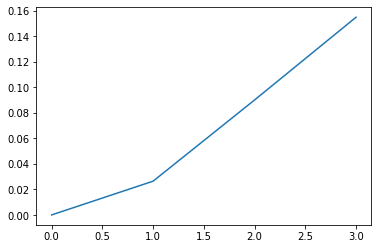

In [6]:
plt.plot(np.arange(num_steps + 1), entropies / subsystem_size)

In [7]:
probs = np.sum(np.square(np.abs(statevector)), axis=0)
indices = np.arange(2 ** subsystem_size, dtype=np.uint8).reshape((-1, 1))
bitarray = np.unpackbits(indices, axis=1)
electron_numbers = np.sum(1 - bitarray[:, 0::2], axis=1, dtype=np.int) - np.sum(bitarray[:, 1::2], axis=1, dtype=np.int)

dist = np.zeros(subsystem_size + 1)
for n in range(-subsystem_size // 2, subsystem_size // 2 + 1):
    idx = np.nonzero(electron_numbers == n)[0]
    dist[n + subsystem_size // 2] += np.sum(probs[idx])

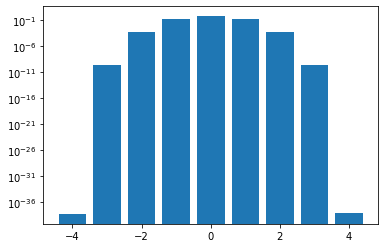

In [8]:
plt.bar(np.linspace(-(subsystem_size // 2), subsystem_size // 2, subsystem_size + 1), dist)
plt.yscale('log')